# Neural style transfer - Transferência de Estilo Neural




<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
</table>

# Este tutorial usa aprendizado profundo para compor uma imagem no estilo de outra imagem (você já desejou pintar como Picasso ou Van Gogh?). Isso é conhecido como transferência de estilo neural e a técnica é descrita em A Neural Algorithm of Artistic Style (Gatys et al.).

# Nota: Este tutorial demonstra o algoritmo de transferência de estilo original. Otimiza o conteúdo da imagem para um estilo específico. As abordagens modernas treinam um modelo para gerar a imagem estilizada diretamente (semelhante ao CycleGAN). Essa abordagem é muito mais rápida (até 1000x).

# Para uma aplicação simples de transferência de estilo com um modelo pré-treinado do TensorFlow Hub, confira o tutorial Transferência rápida de estilo para estilos arbitrários que usa um modelo de estilização de imagem arbitrário. Para ver um exemplo de transferência de estilo com o TensorFlow Lite, consulte Transferência de estilo artístico com o TensorFlow Lite.






This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.).

Note: This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to [CycleGAN](./cyclegan.ipynb)). This approach is much faster (up to 1000x).

For a simple application of style transfer with a pretrained model from [TensorFlow Hub](https://tfhub.dev), check out the [Fast style transfer for arbitrary styles](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) tutorial that uses an [arbitrary image stylization model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2). For an example of style transfer with [TensorFlow Lite](https://www.tensorflow.org/lite), refer to [Artistic style transfer with TensorFlow Lite](https://www.tensorflow.org/lite/examples/style_transfer/overview). *texto em itálico*

# A transferência de estilo neural é uma técnica de otimização usada para pegar duas imagens - uma imagem de *conteúdo* e uma imagem de *referência de estilo* (como uma obra de arte de um pintor famoso) - e combiná-las para que a imagem de saída se pareça com a imagem do conteúdo, mas “pintado” no estilo da imagem de referência de estilo.

# Isso é implementado otimizando a imagem de saída para corresponder às estatísticas de conteúdo da imagem de conteúdo e às estatísticas de estilo da imagem de referência de estilo. Essas estatísticas são extraídas das imagens por meio de uma rede convolucional.






Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

## Setup


### Import and configure modules

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [11]:
#content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')



content_path = '/content/arara.jpeg'
style_path = '/content/Monacat.jpg'

## Visualize the input

## Defina uma função para carregar uma imagem e limitar sua dimensão máxima a 512 pixels.

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [12]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [13]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

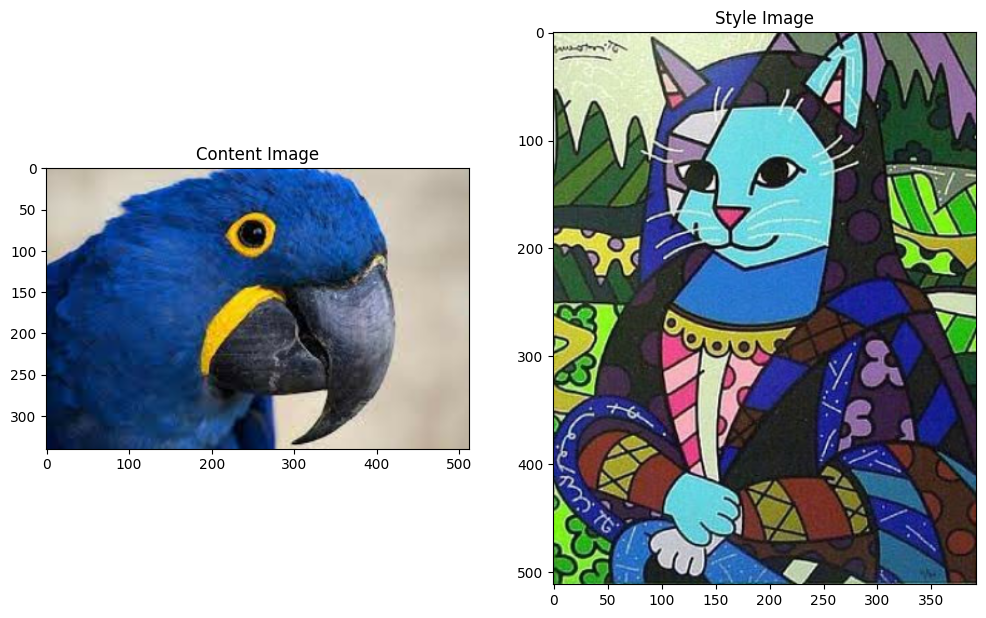

In [14]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

#Transferência rápida de estilo usando TF-Hub

# Este tutorial demonstra o algoritmo original de transferência de estilo, que otimiza o conteúdo da imagem para um estilo específico. Antes de entrar em detalhes, vamos ver como o [modelo do TensorFlow Hub](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) faz isso:

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

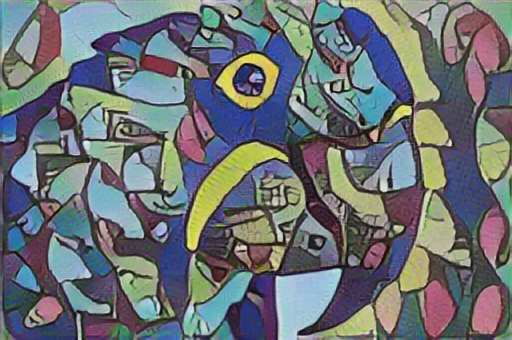

In [16]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)


# Definir representações de conteúdo e estilo
# Use as camadas intermediárias do modelo para obter as representações de *conteúdo* e *estilo* da imagem. Começando pela camada de entrada da rede, as primeiras ativações de camada representam recursos de baixo nível, como bordas e texturas. À medida que você avança pela rede, as camadas finais representam recursos de nível superior — partes de objetos como *rodas* ou *olhos*. Neste caso, você está usando a arquitetura de rede VGG19, uma rede de classificação de imagens pré-treinada. Essas camadas intermediárias são necessárias para definir a representação do conteúdo e do estilo das imagens. Para uma imagem de entrada, tente combinar o estilo correspondente e as representações de destino de conteúdo nessas camadas intermediárias.

 Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.
